Import dependencies and pollen data

In [1]:
import h5py
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, losses, optimizers, metrics
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

Let's check that the GPU is detected

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We import all the data, already prepared

In [3]:
f = h5py.File('proc_data.h5', 'r')

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = np.array(f['X_train']), np.array(f['Y_train']), np.array(f['X_dev']), np.array(f['Y_dev']), f['X_test'], f['Y_test']

m_train = X_train.shape[0]
window_size = X_train.shape[1] + 1
n = X_train.shape[2]

print(X_train.shape)

(67126, 6, 12)


Finally, we can start building our model!

In [4]:
X_in = Input(shape=(window_size - 1, n))
X = LSTM(20, dropout=0)(X_in)
X_out = Dense(units=1, activation='linear')(X)

model = Model(inputs=X_in, outputs=X_out)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 12)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                2640      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,661
Trainable params: 2,661
Non-trainable params: 0
_________________________________________________________________


In [6]:
opt = Adam(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.99, epsilon=1e-7, clipnorm=10)
model.compile(loss='mse', optimizer=opt)

In [32]:
fitting = model.fit(X_train, Y_train, batch_size=512, epochs = 20, validation_data=(X_dev, Y_dev), shuffle=True)

Epoch 1/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5665 - val_loss: 0.5749
Epoch 2/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5650 - val_loss: 0.5846
Epoch 3/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5638 - val_loss: 0.5794
Epoch 4/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5658 - val_loss: 0.5768
Epoch 5/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5647 - val_loss: 0.5753
Epoch 6/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5656 - val_loss: 0.5763
Epoch 7/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5670 - val_loss: 0.5776
Epoch 8/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5648 - val_loss: 0.5761
Epoch 9/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5656 - val_loss: 0.5768
Epoch 10/20
132/132 [==============================] - 1s 8ms/step - loss: 0.5644 - val_loss: 0.5780

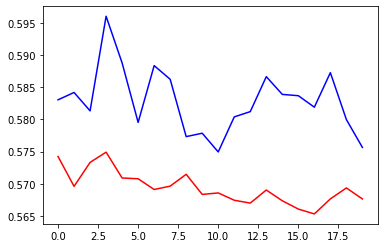

In [28]:
plt.plot(np.array(fitting.history['loss']), color='r')
plt.plot(np.array(fitting.history['val_loss']), color='b')
plt.show()

- v1.0 val_loss = 3.175 after 400 epochs
- v1.1 val_loss = 1.797 after 400 epochs
    - Added precipitation data
- v1.2 val_loss = 0.716 after 400 epochs
    - Added a log kernel to pollen data
    
- v2.0 val_loss = 1130 after 110 epochs
    - Trained with all the data
- v2.1 val_loss = 0.57 after 100 epochs
    - fixed normalization lol

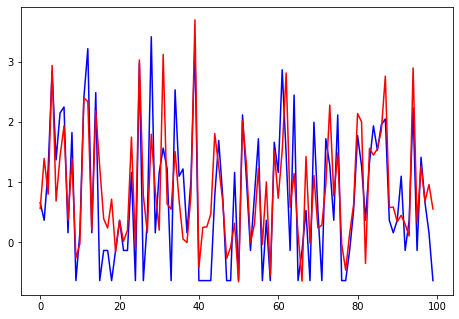

In [31]:
pollen_mean, pollen_std = f['parameters']

start_pred = 0
end_pred = 100

Y_true = Y_dev[start_pred:end_pred]
Y_pred = model(X_dev)[start_pred:end_pred]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.plot(Y_true, color='b')
ax.plot(Y_pred, color='r')

plt.show()

Here we plot the data directly as it is, with the log kernel, and in the next cell reverted back to the original values. I plotted it in the original distribution because I suspect that it is what I will use when I classify the predictions into a few classes or 'levels' of pollen in air. This is because, as I have said earlier, what we need a lot of sensitivity to large changes in pollen levels, while changes in the low-end values are irrelevant to the app's intent.

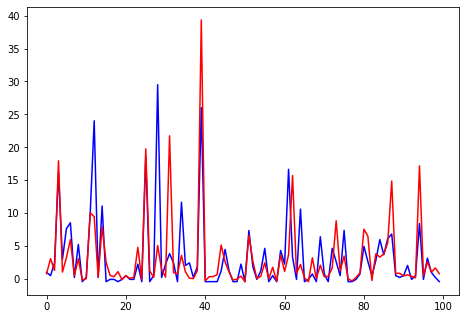

In [30]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.plot(np.exp(Y_true) - 1, color='b')
ax.plot(np.exp(Y_pred) - 1, color='r')

plt.show()

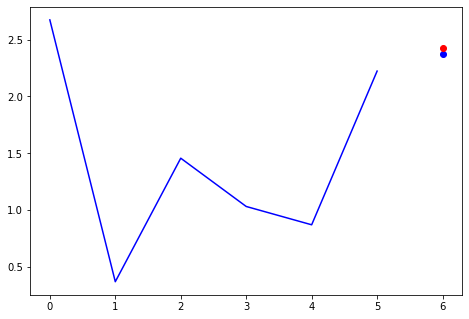

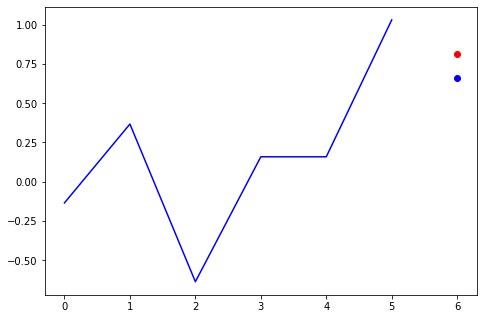

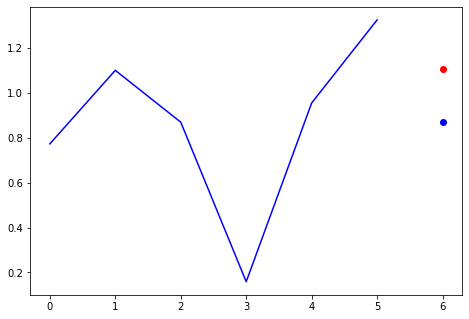

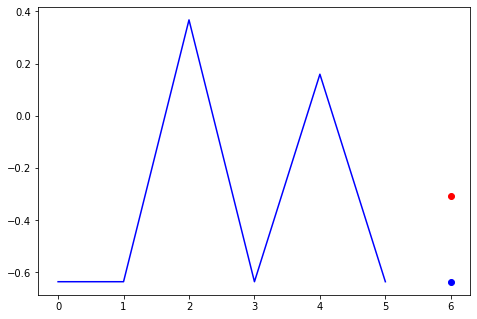

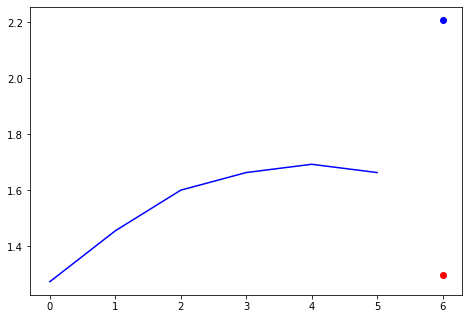

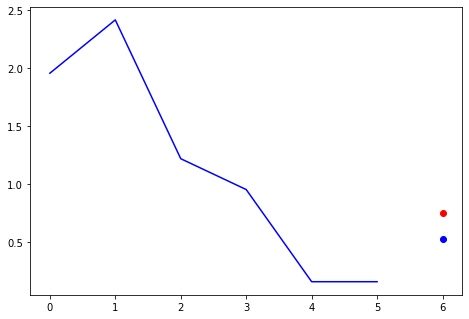

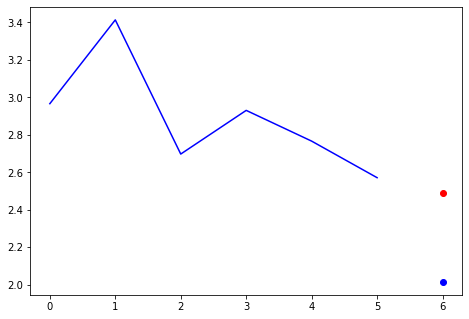

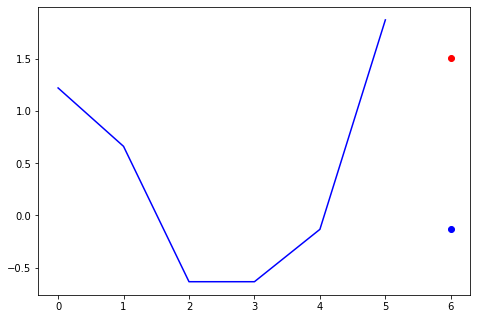

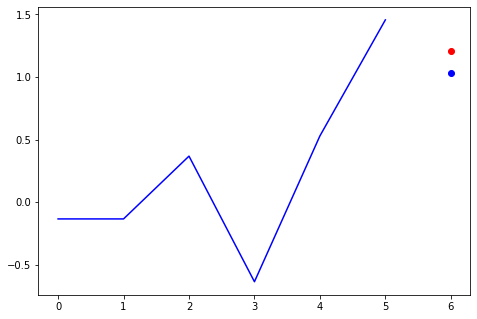

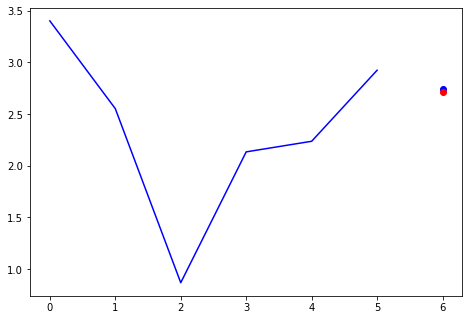

In [26]:
start_windows = 150
end_windows = 160

X_pred = X_dev[start_windows:end_windows]
Y_pred = model(X_pred)
Y_real = Y_dev[start_windows:end_windows]

for i in range(end_windows - start_windows):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.plot(range(window_size - 1), X_pred[i, : , 0] , color = 'b')
    ax.scatter(window_size - 1, Y_real[i], color = 'b')
    ax.scatter(window_size - 1, Y_pred[i], color='r')
    
    fig.show()
    
#plt.show()